# Projection Method を使用した3期間のモデルの解き方

In [62]:
# パッケージのインポート

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import leastsq

## 1. カリブレーション

In [63]:
# カリブレーション

beta = 0.985 ** 20
gamma = 2.0
r = 1.025 ** 20 -1
y_1 = 1
y_2 = 1.2
y_3 = 0.4 

## 二期目の政策関数を求める

### 手順
1. 二期目の評価点$\{a_{2,i}\}_{i=0}^{N}$を作成
2. 二期目の残差関数を定義
    
    $R(\theta_0, \theta_1, a_{2,i}) = \beta(1+r)\dfrac{(y_3 + (1+r)(\theta_0 + \theta_1 a_{2,i}))^{-\gamma}}{(y_2 + (1+r)a_2 - (\theta_0 + \theta_1 a_{2,i}))^{-\gamma}} -1$
    
3. $\theta_0, \theta_1$を引数として、評価点$a_{2,j}$ごとの残差を計算し、配列として出力する関数を定義(calc_residual(θ))
4. calc_residualが返す配列から残差二乗和を計算し，この残差二乗和を最小化する$\theta_0^\star, \theta_1^\star$を探索するアルゴリズム(scipy.optimize.leastsq)を用いて，二期目の政策関数$g_2(a_1) = \theta_0^\star + \theta_1^\star a_1$ を決定する

In [64]:
# 1. 二期目の評価点を作成
a2_grid = np.linspace(0.025, 2.0, 80)

In [65]:
# 2. 二期目の残差関数を定義
def R(theta: npt.NDArray, a_2) -> float:
    theta0, theta1 = theta
    a_3 = theta0 + theta1 * a_2 # 三期目の資産 == 二期目の政策関数
    w_2= y_2 + (1 + r) * a_2 # 二期目の所得
    w_3 = y_3 + (1 + r) * a_3 # 三期目の所得

    # ペナルティの条件式
    if a_3 < 0: # 三期目の資産が負の値を取る場合, 残差をわずかに変化する非常に大きな値にする
        return 10**5 - a_3
    if w_2 < a_3: # 三期目の資産が二期目の所得より大きい場合, 残差をわずかに変化する非常に大きな値にする
        return 10**5 + a_3
    
    residual = beta * (1 + r) * w_3 ** (-gamma) / (w_2 - a_3) ** (-gamma) - 1
    
    return residual

In [66]:
# 3. 評価点ごとの残差を計算し配列として返却する calc_residuals 関数を定義
def calc_residuals_g2(theta):
    residuals = np.zeros(len(a2_grid))
    for i, a_2 in enumerate(a2_grid):
        residuals[i] = R(theta, a_2)
    
    return residuals

In [67]:
# 4. この残差二乗和を最小化するアルゴリズムを用いて，二期目の政策関数を決定する
theta = leastsq(calc_residuals_g2, [0.1, 0.1])[0]
print(theta)

[0.3361025  0.65835993]


## 一期目の政策関数を求める

1. 一期目の評価点$a_{1,j}$を作成する
2. 一期目の残差関数を定義
  $R(\eta_0, \eta_1, a_{1,i}) = \beta(1+r)\dfrac{(y_2 + (1+r)(\eta_0 + \eta_1 a_{1,i}) - (\theta_0^\star + \theta_1^\star (\eta_0 + \eta_1 a_{1.i})))^{-\gamma}}{(y_1 + a_1 - (\eta_0 + \eta_1 a_{1,i}))^{-\gamma}} -1$

3. $\theta_0, \theta_1$を引数として、評価点$a_{1,j}$ごとの残差を計算し、配列として出力する関数を定義(calc_residual(θ))
4. calc_residualが返す配列から残差二乗和を計算し，この残差二乗和を最小化する$\theta_0^\star, \theta_1^\star$を探索するアルゴリズム(scipy.optimize.leastsq)を用いて，二期目の政策関数$g_1(a_1) = \eta_0^\star + \eta_1^\star a_1$ を決定する

In [68]:
# 1. 一期期目の評価点を作成
a1_grid = np.linspace(0.025, 2.0, 80)

In [69]:
# 2. 一期目の残差関数を定義
def R(eta, a_1):
    eta0, eta1 = eta
    a_2 = eta0 + eta1 * a_1
    a_3 = theta[0] + theta[1] * a_2
    w_1 = y_1 + a_1
    w_2 = y_2 + (1 + r) * a_2

    # ペナルティの条件式
    if a_2 < 0:
        return 10**5 - a_2
    if w_1 < a_2:
        return 10**5 + a_2

    residual = beta * (1 + r) * (w_2 - a_3) ** (-gamma) / (w_1 - a_2) ** (-gamma) - 1

    return residual

In [70]:
# 3. 評価点ごとの残差を計算し配列として返却する calc_residuals 関数を定義
def calc_residuals_g1(eta):
    residuals = np.zeros(len(a1_grid))
    for i, a_1 in enumerate(a1_grid):
        residuals[i] = R(eta, a_1)
    
    return residuals

In [71]:
# 4. 残差二乗和を最小化するアルゴリズムを用いて，一期目の政策関数を決定する
eta = leastsq(calc_residuals_g1, [0.1, 0.1])[0]
print(eta)

[0.11372162 0.52890044]


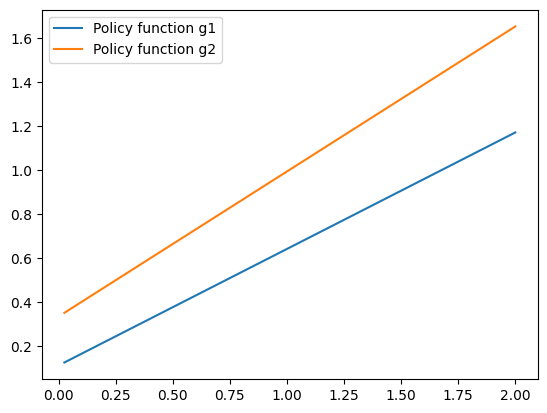

In [72]:
# 制作関数を二つ並べてプロット
fig, ax = plt.subplots()
ax.plot(a1_grid, [(eta[0] + eta[1] * a) for a in a1_grid], label="Policy function g1")
ax.plot(a2_grid, [(theta[0] + theta[1] * a) for a in a2_grid], label="Policy function g2")
ax.legend()
plt.show()

In [61]:
# 変数を初期化したいときに叩く
# %reset -f